In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import transforms
from torchvision.models import ResNet18_Weights, ResNet34_Weights
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

In [25]:
def get_train_val(filepath: str, val_size=0.2):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1] = int(row[1])-1
            new_row = [row[0], row[1]]
            data.append(new_row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id'])
    train_df, val_df = train_test_split(df, test_size=val_size, stratify=df['class_id'], shuffle=True, random_state=42)
    return train_df, val_df

def get_test(filepath: str):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1] = int(row[1])-1
            new_row = [row[0], row[1]]
            data.append(new_row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id'])
    return df

def load_and_transform_image(image_path, transformations):
    transform = transforms.Compose(transformations)
    image = Image.open(image_path).convert('RGB')  # Convert all images to RGB
    return transform(image)

def create_dataset(df, base_path, transformations):
    images_tensors = []
    y = []
    for row in df.values.tolist():
        image_id, class_id = row[0], row[1]
        image_path = f"{base_path}{image_id}.jpg" 
        image_tensor = load_and_transform_image(image_path, transformations)
        images_tensors.append(image_tensor)
        y.append(class_id)
    
    X = torch.stack(images_tensors)
    y = torch.tensor(np.array(y))
    return X, y

In [26]:
df_train, df_val = get_train_val('datasets/annotations/trainval.txt')
transformations = [
    transforms.Resize((224, 224)),             # Resize the images to 224x224 pixels
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
]
X_train, y_train = create_dataset(df_train, base_path='datasets/images/', transformations=transformations)
X_val, y_val = create_dataset(df_val, base_path='datasets/images/', transformations=transformations)

In [27]:
X_train

tensor([[[[ 1.0331,  1.0159,  1.0159,  ...,  1.0502,  1.0331,  1.0331],
          [ 1.0159,  1.0673,  1.2728,  ...,  0.3823,  0.9132,  1.0331],
          [ 1.0159,  1.2043,  2.0605,  ..., -1.6727,  0.5536,  1.0159],
          ...,
          [ 1.0159,  1.1015,  1.3584,  ..., -1.1760,  0.5364,  1.0331],
          [ 0.9988,  1.0673,  1.2043,  ...,  0.4337,  0.9132,  1.0331],
          [ 1.0159,  1.0331,  0.9988,  ...,  1.0331,  1.0331,  1.0331]],

         [[ 1.1856,  1.1681,  1.1681,  ...,  1.1681,  1.1681,  1.1856],
          [ 1.1681,  1.2206,  1.4307,  ...,  0.5028,  1.0805,  1.1856],
          [ 1.1681,  1.3606,  2.2360,  ..., -1.5630,  0.7479,  1.1856],
          ...,
          [ 1.1681,  1.2906,  1.6408,  ..., -0.5826,  0.8704,  1.1856],
          [ 1.1856,  1.2206,  1.3606,  ...,  0.7304,  1.0805,  1.1506],
          [ 1.1681,  1.1856,  1.1506,  ...,  1.1856,  1.1681,  1.1681]],

         [[ 1.4025,  1.3851,  1.3851,  ...,  1.4200,  1.4200,  1.3851],
          [ 1.3851,  1.4374,  

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):

        images, labels = batch 
        out = self(images)
        with torch.no_grad():
            loss = F.cross_entropy(out, labels)   
            acc = accuracy(out, labels)           
        return {'loss': loss.detach(), 'acc': acc}
    

# Function to disable the gradient computation for the initial layers of the network.
def set_parameter_requires_grad(model, layer_freezing_depth, fine_tune_last_layer_only=True):
    if fine_tune_last_layer_only:
        for name, param in model.named_parameters():
            if "fc" not in name:  # The final layer is named 'fc'
                param.requires_grad = False  # NOTE: Freezes all parameters except the final layer
            else:
                param.requires_grad = True  # NOTE: Keeps the final layer trainable
        return
    
    child_counter = 0
    for child in model.children():
        if child_counter < layer_freezing_depth:
            for param in child.parameters():
                param.requires_grad = False  # NOTE: Freezes the parameters so they won't update during training
        else:
            for param in child.parameters():
                param.requires_grad = True
        child_counter += 1

# Creates an optimizer that only updates the trainable layers
def get_optimizer(model, base_lr):
    params_to_update = [param for param in model.parameters() if param.requires_grad]
    return torch.optim.Adam(params_to_update, lr=base_lr)
    

class DogsCatsCnnModelResNet(ImageClassificationBase):
    def __init__(self, resnet=18, freeze_bn=True, fine_tune_last_layer_only=True, layer_freezing_depth=None):
        super().__init__()
        if resnet == 18:
            self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        elif resnet == 34:
            self.network = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 37)

        set_parameter_requires_grad(self.network, layer_freezing_depth, fine_tune_last_layer_only)
        if freeze_bn:
            for module in self.network.modules():
                if isinstance(module, nn.BatchNorm2d):
                    module.eval()  # NOTE: Sets batch norm layers to evaluation mode, which uses running means and variances
                    for param in module.parameters():
                        param.requires_grad = False  # NOTE: Prevents updating of batch norm parameters
    
    def forward(self, xb):
        return self.network(xb)  # Output raw logits directly

    
@torch.no_grad()
def evaluate(model: ImageClassificationBase, X_val, Y_val):
    model.eval()
    batch = [X_val, Y_val]
    outputs = model.validation_step(batch)
    return outputs

def augment_batch(batch):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    ])
    images, labels = batch
    augmented_images = torch.stack([transform(image) for image in images])
    return augmented_images, labels


def fit(model: ImageClassificationBase, epochs, lr, X_train, Y_train, X_val, Y_val, batch_size=32, augment=True):

    history = {
        'val': [],
        'train': []
    }
    optimizer = get_optimizer(model, lr)

    # Create TensorDataset and DataLoader for training data
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Evaluate on no training first
    result_val = evaluate(model, X_val, Y_val)
    result_train = evaluate(model, X_train, Y_train)
    history['val'].append(result_val)
    history['train'].append(result_train)
    print(f"Epoch 0, val: {result_val}")
    print(f"Epoch 0, train: {result_train}")

    min_loss = np.inf
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
                
        # Training Phase 
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader):
            print(f"  - Batch {i}/{int(len(X_train) / batch_size)}")
            if augment:
                batch = augment_batch(batch)  # NOTE: Augments the batch if augment flag is True
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result_val = evaluate(model, X_val, Y_val)
        result_train = evaluate(model, X_train, Y_train)
        history['val'].append(result_val)
        history['train'].append(result_train)
        print(f"    > val: {result_val}")
        print(f"    > train: {result_train}")

        if result_val['loss'] < min_loss:
            min_loss = result_val['loss']
            best_model = model
        
    return best_model, history

In [30]:
def plot_results(history):
    val_hist = history['val']
    train_hist = history['train']
    val_loss = [d['loss'] for d in val_hist]
    val_acc = [d['acc'] for d in val_hist]
    train_loss = [d['loss'] for d in train_hist]
    train_acc = [d['acc'] for d in train_hist]

    plt.style.use('dark_background')

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Update')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.xlabel('Update')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
num_epochs = 5
batch_size = 128
lr = 0.00025

model_resnet_18 = DogsCatsCnnModelResNet(resnet=34, freeze_bn=False, fine_tune_last_layer_only=False, layer_freezing_depth=5)
best_model, history = fit(model_resnet_18, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, augment=True)

Epoch 0, val: {'loss': tensor(3.9293), 'acc': tensor(0.0190)}
Epoch 0, train: {'loss': tensor(3.8771), 'acc': tensor(0.0183)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.9825), 'acc': tensor(0.7283)}
    > train: {'loss': tensor(0.6781), 'acc': tensor(0.8003)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

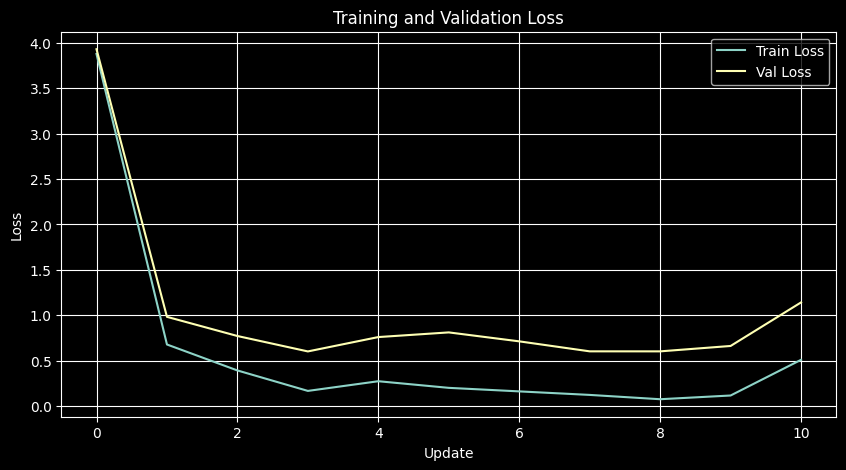

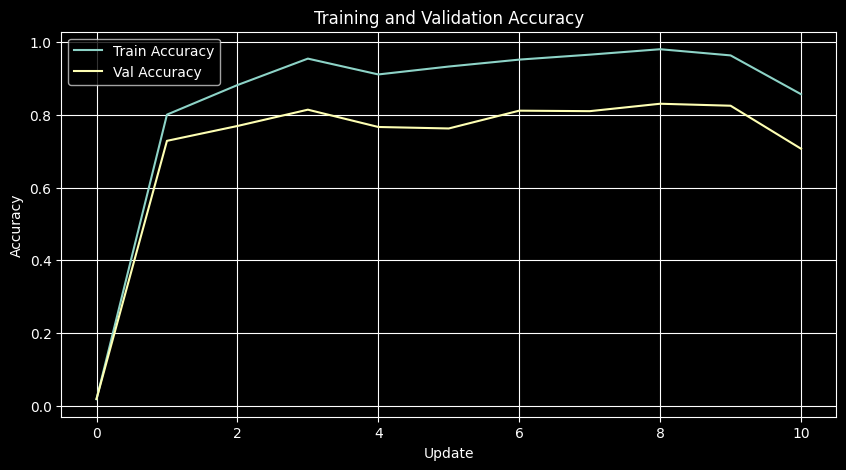

In [31]:
plot_results(history)

In [32]:
num_epochs = 5
batch_size = 128
lr = 0.00025

model_resnet_18 = DogsCatsCnnModelResNet(resnet=34, freeze_bn=False, fine_tune_last_layer_only=False, layer_freezing_depth=0)
best_model, history = fit(model_resnet_18, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, augment=True)

Epoch 0, val: {'loss': tensor(4.0186), 'acc': tensor(0.0231)}
Epoch 0, train: {'loss': tensor(4.0017), 'acc': tensor(0.0251)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.7033), 'acc': tensor(0.7840)}
    > train: {'loss': tensor(0.4632), 'acc': tensor(0.8645)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

In [33]:
num_epochs = 5
batch_size = 128
lr = 0.00025

model_resnet_18 = DogsCatsCnnModelResNet(resnet=34, freeze_bn=False, fine_tune_last_layer_only=False, layer_freezing_depth=0)
best_model, history = fit(model_resnet_18, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, augment=False)

Epoch 0, val: {'loss': tensor(3.9617), 'acc': tensor(0.0245)}
Epoch 0, train: {'loss': tensor(3.9773), 'acc': tensor(0.0241)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(1.1570), 'acc': tensor(0.6712)}
    > train: {'loss': tensor(0.7459), 'acc': tensor(0.7908)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

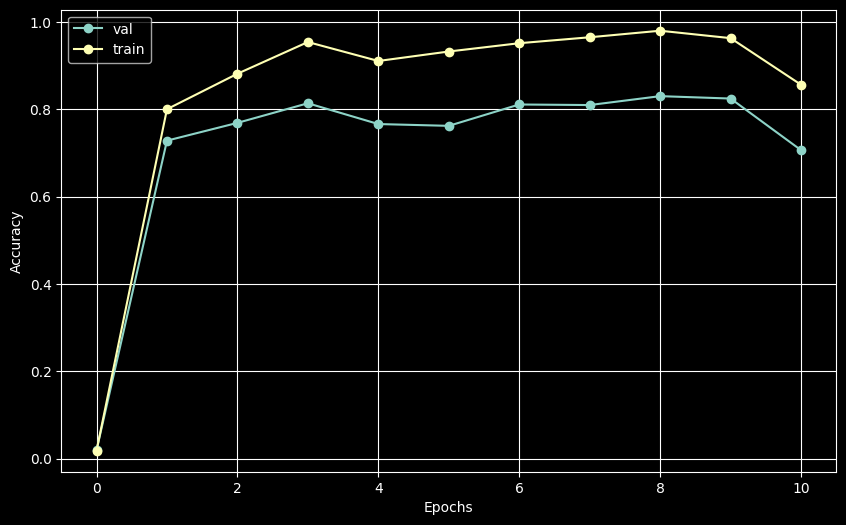

In [36]:
# Data parsed from the log
epochs = list(range(11))
val_acc = [0.0190, 0.7283, 0.7690, 0.8139, 0.7663, 0.7622, 0.8111, 0.8098, 0.8302, 0.8247, 0.7065]
train_acc = [0.0183, 0.8003, 0.8815, 0.9541, 0.9107, 0.9324, 0.9514, 0.9650, 0.9800, 0.9630, 0.8563]

# Plotting
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

plt.plot(epochs, val_acc, label='val', marker='o')
plt.plot(epochs, train_acc, label='train', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()